In [14]:
from google.colab import files

uploaded = files.upload()  # This will open a file chooser
print(uploaded.keys())


Saving diabetes_dataset.csv to diabetes_dataset (1).csv
dict_keys(['diabetes_dataset (1).csv'])


In [16]:
# Cell 1 - Imports and load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # for heatmap
from pathlib import Path
from IPython.display import display, Markdown

# path to uploaded csv

import io
df = pd.read_csv(io.BytesIO(uploaded['diabetes_dataset (1).csv']))
df.head()



# detect target column (adjust if necessary)
target_col = "diabetes" if "diabetes" in df.columns else df.columns[-1]

display(Markdown("### Basic info"))
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("Detected target:", target_col)
display(df.head())


### Basic info

Shape: (100000, 9)
Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
Detected target: diabetes


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0.0,1.0,never,25.19,6.6,140.0,0.0
1,Female,NaN,0.0,0.0,No Info,27.32,6.6,80.0,0.0
2,Male,28.0,0.0,0.0,never,27.32,NaN,158.0,0.0
3,Female,36.0,0.0,0.0,NaN,23.45,5.0,155.0,0.0
4,Male,76.0,1.0,1.0,current,20.14,4.8,NaN,NaN


In [17]:
# Cell 2 - Dataset description
n_features = df.shape[1] - 1
n_points = df.shape[0]

print("Number of features (excluding target):", n_features)
# classify problem type: if target is categorical with few unique values -> classification
print("Target unique values:", df[target_col].nunique()) # binary 0 anf 1
print("Target value counts:\n", df[target_col].value_counts(dropna=False))
print("Problem type:", "Classification" if df[target_col].nunique() <= 20 else "Regression")


Number of features (excluding target): 8
Target unique values: 2
Target value counts:
 diabetes
0.0    82284
NaN    10082
1.0     7634
Name: count, dtype: int64
Problem type: Classification


In [18]:
# Cell 3 - EDA: types and missing values
display(Markdown("### Feature types"))
display(df.dtypes)

display(Markdown("### Null / missing counts"))
display(df.isnull().sum())

# show sample stats
display(df.describe(include='all').T)


### Feature types

,0
gender,object
age,float64
hypertension,float64
heart_disease,float64
smoking_history,object
bmi,float64
HbA1c_level,float64
blood_glucose_level,float64
diabetes,float64


### Null / missing counts

,0
gender,9835
age,10065
hypertension,10148
heart_disease,9919
smoking_history,9988
bmi,9944
HbA1c_level,10139
blood_glucose_level,9880
diabetes,10082


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,90165,3,Female,52721,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,89935.0,NaN,NaN,NaN,41.91052,22.506302,0.08,24.0,43.0,60.0,80.0
hypertension,89852.0,NaN,NaN,NaN,0.075346,0.26395,0.0,0.0,0.0,0.0,1.0
heart_disease,90081.0,NaN,NaN,NaN,0.039143,0.193935,0.0,0.0,0.0,0.0,1.0
smoking_history,90012,6,No Info,32276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,90056.0,NaN,NaN,NaN,27.311793,6.634078,10.01,23.63,27.32,29.57,95.69
HbA1c_level,89861.0,NaN,NaN,NaN,5.528352,1.070551,3.5,4.8,5.8,6.2,9.0
blood_glucose_level,90120.0,NaN,NaN,NaN,137.995018,40.590751,80.0,100.0,140.0,159.0,300.0
diabetes,89918.0,NaN,NaN,NaN,0.0849,0.278734,0.0,0.0,0.0,0.0,1.0


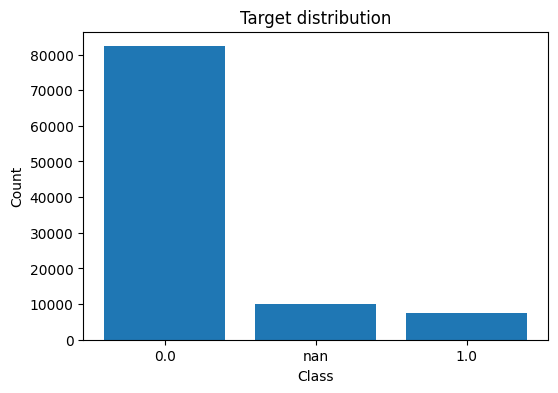

In [19]:
# Cell 4 - Target distribution bar chart
tc = df[target_col].value_counts(dropna=False)
plt.figure(figsize=(6,4))
plt.bar(tc.index.astype(str), tc.values)
plt.title("Target distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


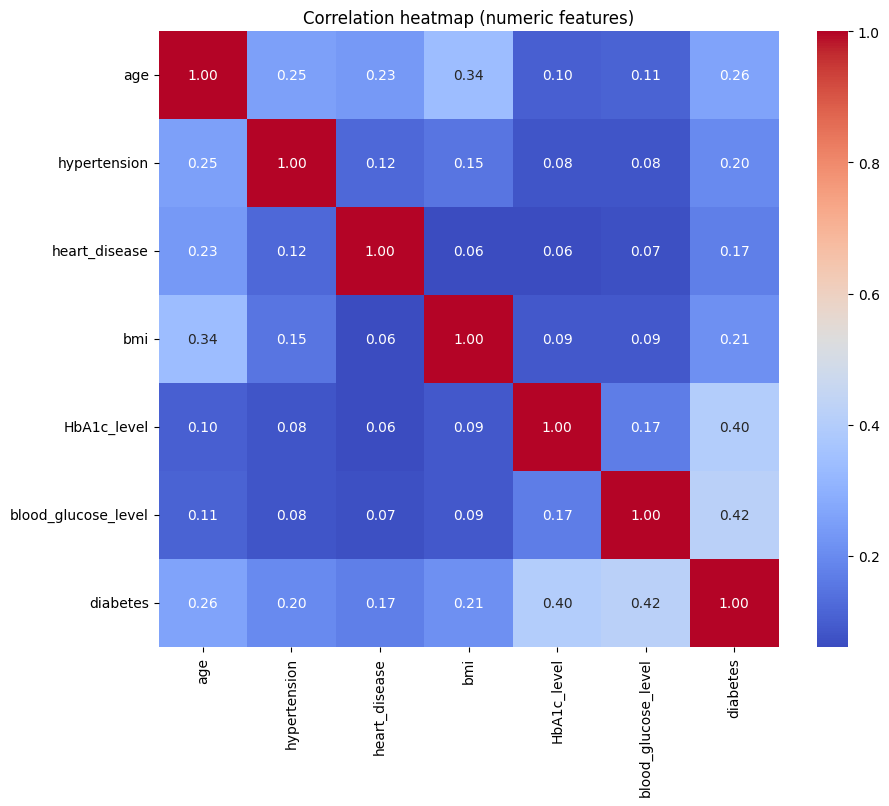

In [20]:
# Cell 5 - Correlation heatmap (numeric only)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(10,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heatmap (numeric features)")
plt.show()




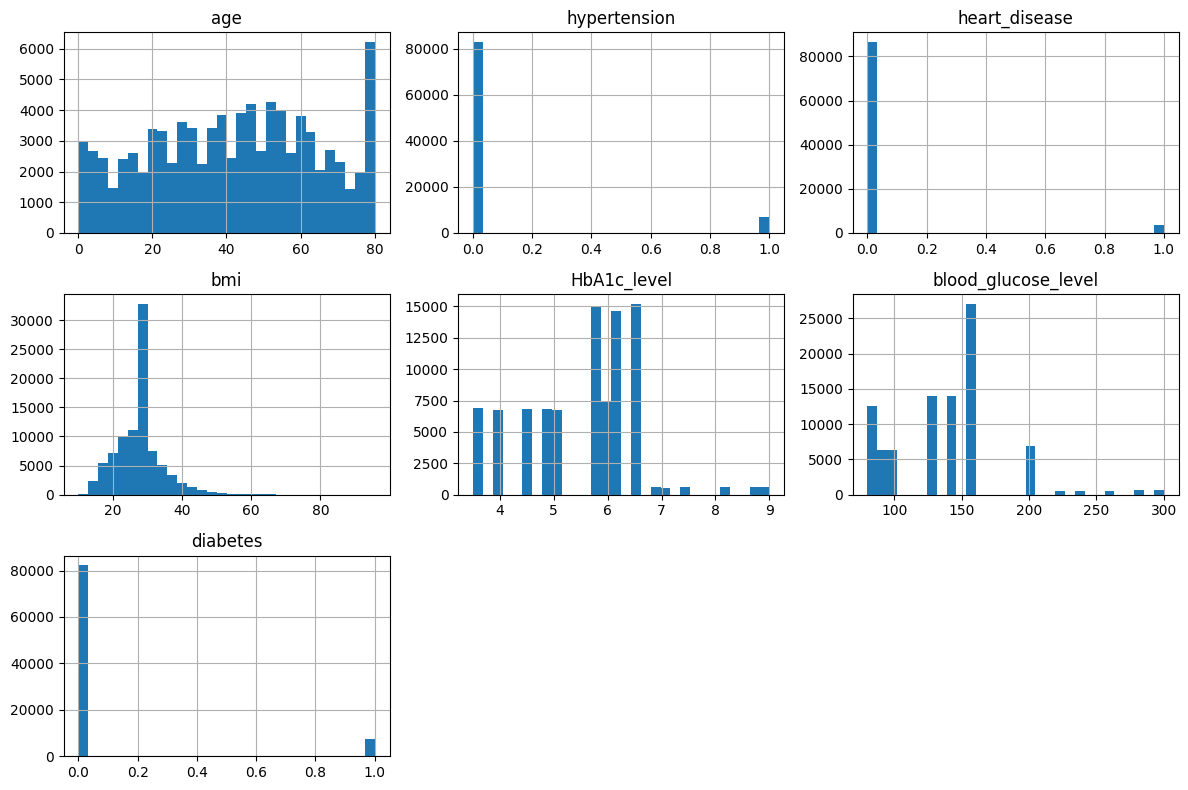

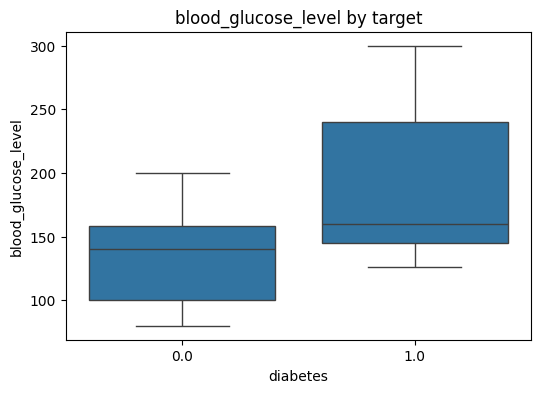

In [21]:
# Cell 6 - EDA plots (examples)
# Histograms for numeric
df[numeric_cols].hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

# Boxplot of a numeric by target (example: blood_glucose_level if present)
if "blood_glucose_level" in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target_col, y="blood_glucose_level", data=df)
    plt.title("blood_glucose_level by target")
    plt.show()


In [22]:
# Cell 7 - Preprocessing (robust to sklearn versions)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import sparse as sp

# Ensure target rows are present
df = df[df[target_col].notna()].copy() #non missin target,all rows #drop where miss

# Identify categorical and numeric columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist() #exclude target
if target_col in cat_cols:
    cat_cols.remove(target_col) #exclude target
num_cols = [c for c in df.columns if c not in cat_cols + [target_col]]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# Build numeric transformer
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  #Imputer fills missing numeric value
    ("scaler", StandardScaler())
])

# Build categorical transformer with compatibility for different sklearn versions
try:
    # newer sklearn uses sparse_output
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
except TypeError:
    # older/newer mismatch - try without sparse_output
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder="drop")

# A small helper function to always return dense numpy arrays
def to_dense(arr):
    if sp.issparse(arr):
        return arr.toarray()
    return arr


Numeric cols: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Categorical cols: ['gender', 'smoking_history']


In [23]:
# Cell 8 - Split and transform (with stratify)
from sklearn.model_selection import train_test_split

# Prepare X and y
X = df.drop(columns=[target_col]) #all columns except the target
y = df[target_col].copy() #target column

# Encode target to numeric if it's categorical/object
if y.dtype == object or y.dtype.name == 'category':
    y = y.astype('category').cat.codes

# If dataset is large and you want a sample, change sample_size (None -> use full)
sample_size = None  # full data set
if sample_size is not None and sample_size < len(df):
    df_sample = df.sample(n=sample_size, random_state=42)
    X = df_sample.drop(columns=[target_col])
    y = df_sample[target_col].astype('category').cat.codes

# Stratified split if possible (need at least 2 classes)
stratify_for_split = y if len(np.unique(y)) > 1 else None  #startify =class proportions in diabetes are preserved   #80% training set,20% test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_for_split
)

# Fit preprocessor on train and transform both sets, converting to dense arrays if needed
preprocessor.fit(X_train) #Median values,frequent,mean & std
X_train_t = to_dense(preprocessor.transform(X_train))  #missin val,one hot
X_test_t  = to_dense(preprocessor.transform(X_test))

print("X_train_t shape:", X_train_t.shape) #sample,feature=15,num=6, one hot2+7
print("X_test_t shape:", X_test_t.shape)


X_train_t shape: (71934, 15)
X_test_t shape: (17984, 15)


In [24]:
# Cell 9 - Helpers: evaluation functions
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve, classification_report)
import matplotlib.pyplot as plt
import itertools

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test) #predicts
    # get probabilities if possible
    y_prob = None #predic probability for auc,else none
    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_prob = model.decision_function(X_test)
    except Exception:
        y_prob = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0) #zero_division=0 prevents errors for non calc
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    print(f"\n--- {name} ---")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)
    print("AUC:", auc)
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

    return {"model": model, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc,
            "y_pred": y_pred, "y_prob": y_prob}


In [25]:
# Cell 10 - Train models (safe / small MLP to avoid long runs)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import time

# If you want to reduce training time, set train_sample to a smaller number
train_sample = None  # full dataset

if train_sample is not None and train_sample < X_train_t.shape[0]:
    idx = np.random.choice(X_train_t.shape[0], train_sample, replace=False) #rabdomly sample select
    X_train_small = X_train_t[idx]
    y_train_small = np.array(y_train)[idx]
else:
    X_train_small = X_train_t
    y_train_small = np.array(y_train)

models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(max_depth=None, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "GaussianNB": GaussianNB(),
    # small MLP to keep runtime short; increase for better performance
    "MLP": MLPClassifier(hidden_layer_sizes=(32,), max_iter=200, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    t0 = time.time() #strttime
    try: #loop no stop if model fails
        model.fit(X_train_small, y_train_small)
    except Exception as e:
        print(f"Error training {name}: {e}")
        continue
    t1 = time.time() #end time
    print(f"Trained {name} in {t1-t0:.1f}s")
    results[name] = evaluate_model(model, X_test_t, np.array(y_test), name=name)

# If results is empty, warn user
if len(results) == 0:
    print("No models were trained (check errors above).")



Training KNN ...
Trained KNN in 0.2s

--- KNN ---
Accuracy: 0.9561832740213523
Precision: 0.8669314796425025
Recall: 0.5717092337917485
F1: 0.6890292028413575
AUC: 0.8869133423417476
Confusion matrix:
 [[16323   134]
 [  654   873]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     16457
         1.0       0.87      0.57      0.69      1527

    accuracy                           0.96     17984
   macro avg       0.91      0.78      0.83     17984
weighted avg       0.95      0.96      0.95     17984


Training DecisionTree ...
Trained DecisionTree in 0.3s

--- DecisionTree ---
Accuracy: 0.9440613879003559
Precision: 0.6679561573178594
Recall: 0.6784544859201048
F1: 0.673164392462638
AUC: 0.8247761754462494
Confusion matrix:
 [[15942   515]
 [  491  1036]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     16457
         1.0       0

In [26]:
# Cell 11 - KMeans clustering (safe)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# number of clusters = number of classes (fallback to 2 if odd)
unique_classes = np.unique(y)
n_clusters = len(unique_classes) if len(unique_classes) >= 2 else 2

# Use a smaller sample for clustering if dataset large
kmeans_sample = X_train_t
if X_train_t.shape[0] > 20000:
    idx = np.random.choice(X_train_t.shape[0], 20000, replace=False)
    kmeans_sample = X_train_t[idx]

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(kmeans_sample)

# Predict clusters for test set (transform already preprocessed)
cluster_labels = kmeans.predict(X_test_t)
ct = pd.crosstab(cluster_labels, np.array(y_test), rownames=['cluster'], colnames=['true'])
print("Contingency table (clusters x true labels):")
print(ct)

# silhouette on sample if possible
try:
    sil = silhouette_score(kmeans_sample, kmeans.predict(kmeans_sample))
    print("Silhouette score (sample):", sil)
except Exception as e:
    print("Silhouette error or not applicable:", e)


Contingency table (clusters x true labels):
true       0.0   1.0
cluster             
0          883   331
1        15574  1196
Silhouette score (sample): 0.41754352904351333


,accuracy,precision,recall,f1,auc
model,,,,,
KNN,0.956183,0.866931,0.571709,0.689029,0.886913
DecisionTree,0.944061,0.667956,0.678454,0.673164,0.824776
LogisticRegression,0.954960,0.858859,0.561886,0.679335,0.945731
GaussianNB,0.623499,0.179070,0.958088,0.301743,0.895681
MLP,0.966804,0.997859,0.610347,0.757416,0.967194


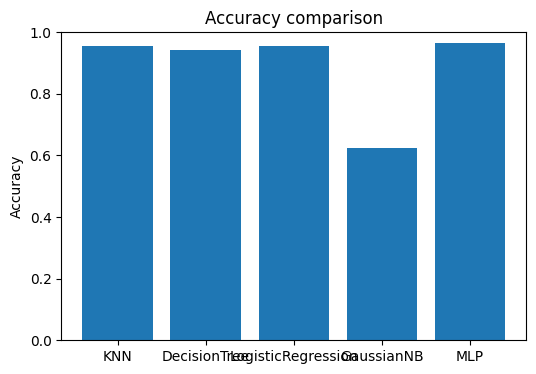

In [27]:
# Cell 12 - Summary table and accuracy bar chart
if len(results) == 0:
    print("No trained model results to summarize.")
else:
    summary = pd.DataFrame([
        {"model": name, "accuracy": v["accuracy"], "precision": v["precision"],
         "recall": v["recall"], "f1": v["f1"], "auc": v["auc"]}
        for name, v in results.items()
    ]).set_index("model")
    display(summary)

    plt.figure(figsize=(6,4))
    plt.bar(summary.index, summary["accuracy"])
    plt.ylim(0,1)
    plt.title("Accuracy comparison")
    plt.ylabel("Accuracy")
    plt.show()


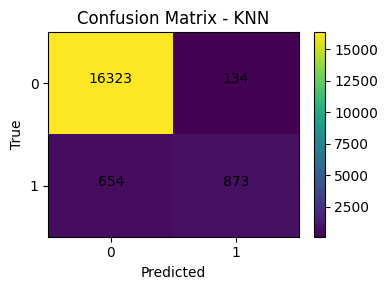

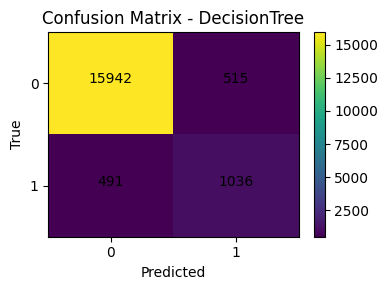

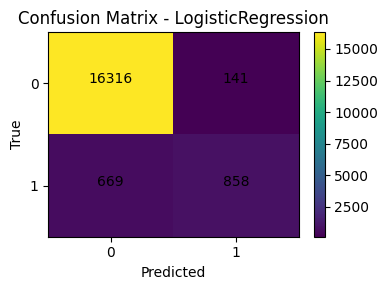

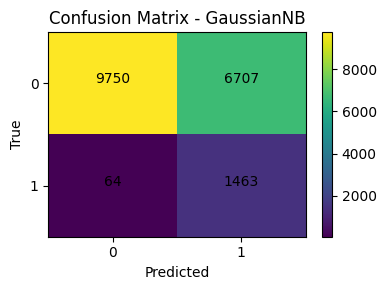

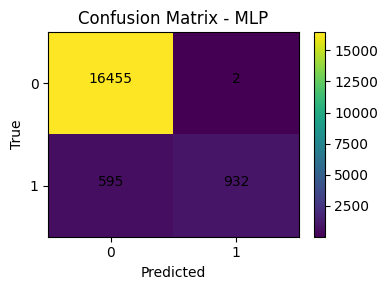

In [28]:
# Cell 13 - Confusion matrices for trained models
if len(results) == 0:
    print("No results for confusion matrices.")
else:
    for name, res in results.items():
        y_pred = res.get("y_pred", None)
        if y_pred is None:
            continue
        cm = confusion_matrix(np.array(y_test), y_pred)
        plt.figure(figsize=(4,3))
        plt.imshow(cm, interpolation='nearest', aspect='auto')
        plt.title(f"Confusion Matrix - {name}")
        plt.colorbar()
        tick = np.arange(cm.shape[0])
        plt.xticks(tick, tick)
        plt.yticks(tick, tick)
        for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i,j], horizontalalignment="center")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()


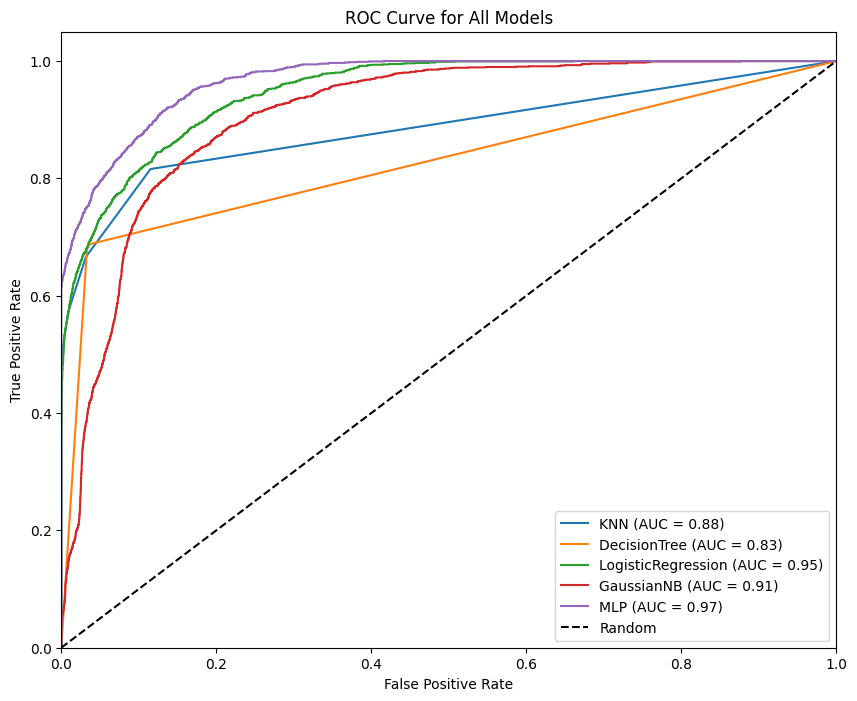

In [29]:
#cell14
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier



# Fill numeric columns with median
num_cols = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical columns with mode
cat_cols = ['gender', 'smoking_history']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Encode categorical columns
le_gender = LabelEncoder()
df['gender'] = le_gender.fit_transform(df['gender'])

le_smoking = LabelEncoder()
df['smoking_history'] = le_smoking.fit_transform(df['smoking_history'])

# Features and target
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Scale features (important for KNN and MLP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models
models = {
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(max_iter=1000)
}

# Plot ROC curves
plt.figure(figsize=(10,8))

for name, model in models.items():
    model.fit(X_train, y_train)

    # Some models have predict_proba, others only decision_function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:,1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot random line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Models')
plt.legend(loc='lower right')
plt.show()


/tmp/ipython-input-678782686.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper right')


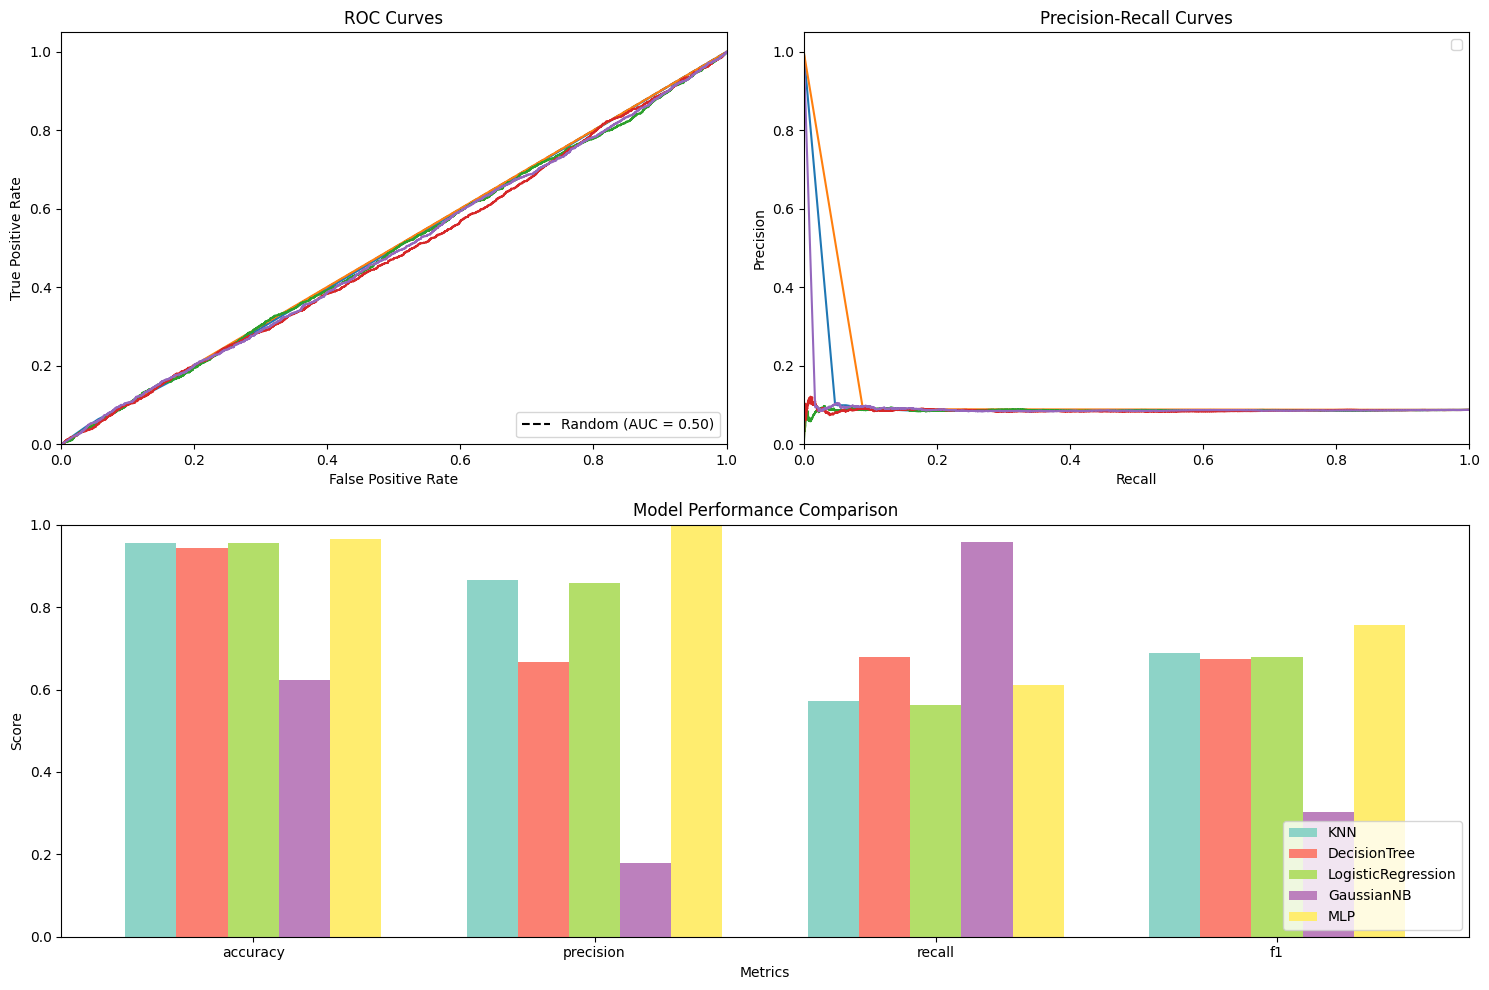


=== Detailed Model Performance ===
Model                AUC      Avg Precision  Accuracy F1-Score
-----------------------------------------------------------------
KNN                  0.498    0.088          0.956    0.689   
DecisionTree         0.501    0.088          0.944    0.673   
LogisticRegression   0.493    0.087          0.955    0.679   
GaussianNB           0.486    0.086          0.623    0.302   
MLP                  0.491    0.087          0.967    0.757   


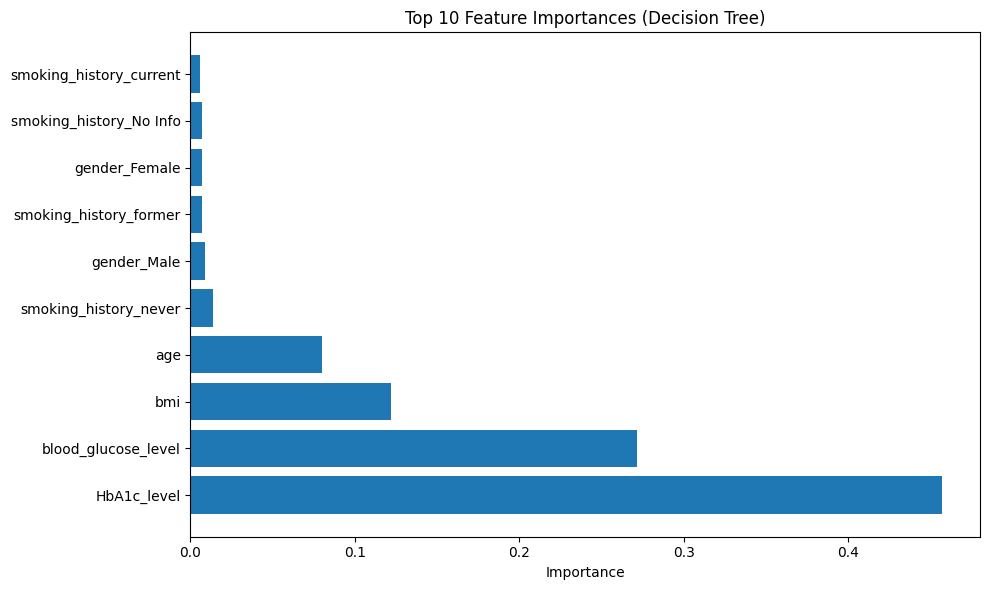

In [32]:
# Cell 14 - Enhanced Model Evaluation with ROC Curves and Precision-Recall Curves
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, average_precision_score)
import matplotlib.gridspec as gridspec

# Use the already preprocessed data from our pipeline (X_test_t, y_test)
# and the models we've already trained in Cell 10

# Create a comprehensive visualization with subplots
plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Plot 1: ROC Curves
ax1 = plt.subplot(gs[0, 0])
ax1.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend(loc='lower right')

# Plot 2: Precision-Recall Curves
ax2 = plt.subplot(gs[0, 1])
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend(loc='upper right')

# Plot 3: Model Performance Comparison
ax3 = plt.subplot(gs[1, :])
metrics = ['accuracy', 'precision', 'recall', 'f1']
x_pos = np.arange(len(metrics))
width = 0.15
colors = plt.cm.Set3(np.linspace(0, 1, len(results)))

# Evaluate each model and plot results
model_metrics = {}
for i, (name, res) in enumerate(results.items()):
    # Get probabilities for ROC and PR curves
    y_prob = res.get("y_prob", None)
    if y_prob is not None:
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)
        ax2.plot(recall, precision, label=f'{name} (AP = {avg_precision:.3f})')

    # Store metrics for bar chart
    model_metrics[name] = [res['accuracy'], res['precision'], res['recall'], res['f1']]

    # Add bars for this model
    ax3.bar(x_pos + i*width, model_metrics[name], width, color=colors[i], label=name)

# Format the comparison chart
ax3.set_xlabel('Metrics')
ax3.set_ylabel('Score')
ax3.set_title('Model Performance Comparison')
ax3.set_xticks(x_pos + width*(len(results)-1)/2)
ax3.set_xticklabels(metrics)
ax3.legend(loc='lower right')
ax3.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print detailed AUC and AP scores
print("\n=== Detailed Model Performance ===")
print(f"{'Model':<20} {'AUC':<8} {'Avg Precision':<14} {'Accuracy':<8} {'F1-Score':<8}")
print("-" * 65)

for name, res in results.items():
    y_prob = res.get("y_prob", None)
    if y_prob is not None:
        auc_score = roc_auc_score(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)
    else:
        auc_score = np.nan
        avg_precision = np.nan

    print(f"{name:<20} {auc_score:<8.3f} {avg_precision:<14.3f} {res['accuracy']:<8.3f} {res['f1']:<8.3f}")

# Add feature importance visualization for tree-based models
if "DecisionTree" in results:
    # Get feature names from the preprocessor
    try:
        # For numeric features
        num_features = num_cols

        # For categorical features
        cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_features = cat_encoder.get_feature_names_out(cat_cols)

        # Combine all feature names
        all_features = list(num_features) + list(cat_features)

        # Get feature importances
        importances = results["DecisionTree"]["model"].feature_importances_

        # Create a DataFrame and sort by importance
        feat_imp = pd.DataFrame({'feature': all_features, 'importance': importances})
        feat_imp = feat_imp.sort_values('importance', ascending=False).head(10)

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(feat_imp['feature'], feat_imp['importance'])
        plt.title("Top 10 Feature Importances (Decision Tree)")
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not plot feature importances: {e}")

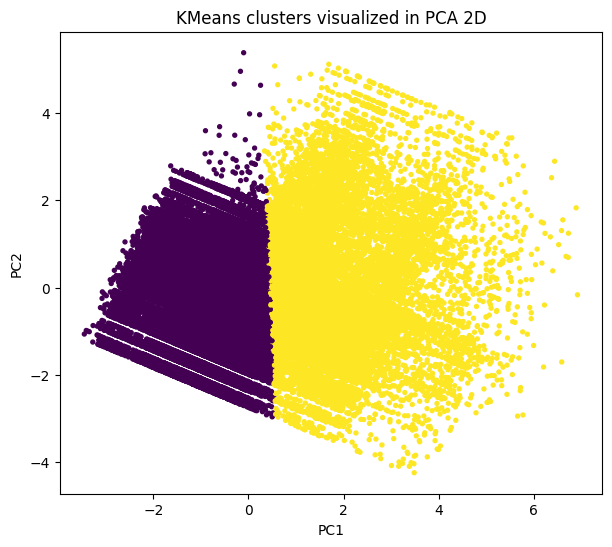

In [33]:
# Cell 16 - PCA + KMeans visualization (2D)
from sklearn.decomposition import PCA

# Preprocess full X (dense)
X_all_t = to_dense(preprocessor.transform(df.drop(columns=[target_col])))

# PCA 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_all_t)

# Fit KMeans on PCA-projected data (for visualization)
kmeans_vis = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(X_pca)
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_vis.labels_, s=8)
plt.title("KMeans clusters visualized in PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
